importation les bibliotheque nécessaire

In [ ]:
#import numpy as np
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier,export_text
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt ##
from sklearn.preprocessing import StandardScaler,normalize,MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report,f1_score,recall_score,accuracy_score,precision_score
#import pandas as pd
#from scipy.io import arff
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

ModuleNotFoundError: No module named 'numpy'

importation les données

In [ ]:
data = arff.loadarff('ckd.arff')  #load a dataset in ARFF (Attribute-Relation File Format)
df=pd.DataFrame(data[0])
df.head()
d=df.describe()
print(d)

              age          bp         bgr          bu          sc         sod  \
count  391.000000  388.000000  356.000000  381.000000  383.000000  313.000000   
mean    51.483376   76.469072  148.036517   57.425722    3.072454  137.528754   
std     17.169714   13.683637   79.281714   50.503006    5.741126   10.408752   
min      2.000000   50.000000   22.000000    1.500000    0.400000    4.500000   
25%     42.000000   70.000000   99.000000   27.000000    0.900000  135.000000   
50%     55.000000   80.000000  121.000000   42.000000    1.300000  138.000000   
75%     64.500000   80.000000  163.000000   66.000000    2.800000  142.000000   
max     90.000000  180.000000  490.000000  391.000000   76.000000  163.000000   

              pot        hemo         pcv          wbcc        rbcc  
count  312.000000  348.000000  329.000000    294.000000  269.000000  
mean     4.627244   12.526437   38.884498   8406.122449    4.707435  
std      3.193904    2.912587    8.990105   2944.474190    1

# **I) Data cleaning** :

enlever la lettre b qu'il est devant les valeurs les features quantitatives

In [ ]:

ty=df.dtypes
colsNam=ty[ty=="object"].index.tolist()
for i in colsNam :
    df[i]= df[i].str.decode('utf-8')
print(df)

      age    bp     sg al su     rbc        pc         pcc          ba    bgr  \
0    48.0  80.0  1.020  1  0       ?    normal  notpresent  notpresent  121.0   
1     7.0  50.0  1.020  4  0       ?    normal  notpresent  notpresent    NaN   
2    62.0  80.0  1.010  2  3  normal    normal  notpresent  notpresent  423.0   
3    48.0  70.0  1.005  4  0  normal  abnormal     present  notpresent  117.0   
4    51.0  80.0  1.010  2  0  normal    normal  notpresent  notpresent  106.0   
..    ...   ...    ... .. ..     ...       ...         ...         ...    ...   
395  55.0  80.0  1.020  0  0  normal    normal  notpresent  notpresent  140.0   
396  42.0  70.0  1.025  0  0  normal    normal  notpresent  notpresent   75.0   
397  12.0  80.0  1.020  0  0  normal    normal  notpresent  notpresent  100.0   
398  17.0  60.0  1.025  0  0  normal    normal  notpresent  notpresent  114.0   
399  58.0  80.0  1.025  0  0  normal    normal  notpresent  notpresent  131.0   

     ...   pcv    wbcc  rbc

## **A)LES Features quantitatives**
# 1) Les valeurs aberrantes
Pour les features quantitatives, On s'interesse aux valeurs aberrantes
qui sont de type "float"
On collecte d'abord les features de type float dans une liste, on parcoure la liste et on cherche les valeurs aberrantes qui sont comprises entre df[i]<Q1-IQR) et (df[i]>Q3+IQR) et on les stocke dans un dictionnaire

In [ ]:
outDic=dict()
ty=df.dtypes
cloNum=ty[ty=="float64"].index.tolist()
val=list
for i in cloNum:
    Q3=df[i].quantile(0.75)
    Q1=df[i].quantile(0.25)
    IQR=1.5*(Q3-Q1)
    val=df[i].values[(df[i]<Q1-IQR)|(df[i]>Q3+IQR)]
    outDic[i]=val
print(outDic)

{'age': array([7., 5., 5., 8., 4., 8., 3., 8., 6., 2.]), 'bp': array([ 50., 100., 100., 100., 100., 100., 100., 100., 100., 100., 110.,
       100., 100., 140., 180., 100., 100.,  50., 100., 100., 100.,  50.,
        50., 110., 100., 100., 100., 120., 100., 100.,  50., 100., 100.,
       100., 100., 110.]), 'bgr': array([423., 410., 490., 380., 263., 264., 270., 425., 360., 360., 415.,
       280., 295., 298., 297., 294., 323., 308., 268., 288., 273., 424.,
       303., 307., 447., 309., 261., 352., 341., 303., 490., 269., 463.,
       424.]), 'bu': array([162., 148., 180., 163., 155., 153., 202., 164., 155., 142., 391.,
       139., 186., 217., 219., 125., 125., 166., 208., 176., 125., 145.,
       165., 322., 235., 132., 146., 133., 153., 137., 223., 158., 132.,
       150., 191., 241., 215., 309.]), 'sc': array([24. ,  7.2,  9.6, 76. ,  7.7,  7.3, 10.8,  6.3,  5.9,  9.7,  7.3,
        6.4, 32. ,  6.1,  6.7,  6.7,  8.5, 15. ,  6.5, 10.2, 11.5,  6.1,
       12.2,  9.2, 13.8, 16.9,  6.

# 2) Les valeurs manquantes


Pour  les features quantitatives, on cherche a remplacer les valeurs manquantes par la valeur de la moyenne de chaque feature.
Pour ce faire, On calcul d'abord le nombre des valeurs manquantes pour chaque features et on les stockent dans une liste "l".
Puis on parcoure la liste l, et on s'interesse aux features dans la somme des valeurs nan est non nulle, on calcule sa valeur moyenne 'moy' et on remplace chaque valeur manquantes par la valeur moyenne.
On verifie enfin l'absence des valeurs manquantes


In [ ]:
l=df.isna().sum()
print("nombre des valeurs Nan pour chaque feature avant ")
print(l)
c=l[df.isna().sum()!=0].index.tolist()
for i in c:
    moy=df[i].mean()
    df[i].values[df[i].isna()]=moy
print("nombre des valeurs Nan pour chaque feature apres ")
print(df.isna().sum())

nombre des valeurs Nan pour chaque feature avant 
age        9
bp        12
sg         0
al         0
su         0
rbc        0
pc         0
pcc        0
ba         0
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        0
dm         0
cad        0
appet      0
pe         0
ane        0
class      0
dtype: int64
nombre des valeurs Nan pour chaque feature avant 
age      0
bp       0
sg       0
al       0
su       0
rbc      0
pc       0
pcc      0
ba       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wbcc     0
rbcc     0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
class    0
dtype: int64


# **B) les features qualitatives**
# 1)les valeurs manquantes:
Pour les features qualitatives, On a choisit de remplacer les les valeurs manquantes de chaque feature par la valeur la plus frequent de chaque feature.
Pour ce faire, on selectionne d'abord les valeurs quantitaives dont le type est "object" dans "colsSTr". On parcourt cette liste, on calcul le mode et pour chaque valeur manquante on la remplace par le mode.
Puis on calcul pour chaque feature qualitative le nombre de repetition pour chaque valeur.

In [ ]:
ty=df.dtypes
colsStr=ty[ty=="object"].index.tolist()
for i in colsStr:
    modeVal=df[i].mode()
    df[i].values[df[i]=="?"]=modeVal
for i in colsStr:
    print("le nombre de repetition pour chaque valeur ",i)
    print(df[i].value_counts())


le nombre de repetition pour chaque valeur  sg
1.020    153
1.010     84
1.025     81
1.015     75
1.005      7
Name: sg, dtype: int64
le nombre de repetition pour chaque valeur  al
0    245
1     44
2     43
3     43
4     24
5      1
Name: al, dtype: int64
le nombre de repetition pour chaque valeur  su
0    339
2     18
3     14
4     13
1     13
5      3
Name: su, dtype: int64
le nombre de repetition pour chaque valeur  rbc
normal      353
abnormal     47
Name: rbc, dtype: int64
le nombre de repetition pour chaque valeur  pc
normal      324
abnormal     76
Name: pc, dtype: int64
le nombre de repetition pour chaque valeur  pcc
notpresent    358
present        42
Name: pcc, dtype: int64
le nombre de repetition pour chaque valeur  ba
notpresent    378
present        22
Name: ba, dtype: int64
le nombre de repetition pour chaque valeur  htn
no     253
yes    147
Name: htn, dtype: int64
le nombre de repetition pour chaque valeur  dm
no     263
yes    137
Name: dm, dtype: int64
le nombre d


# 2)Conversion du qualitative au quantitative :
On remarque que les features "sg","al","su" sont de type "object" alors qu'ils sont des valeur numerique, dont on va convertir ces 3 features qualitatives en des features quantitatives c'est a dire de type "float".
Finalement on calcule le nombre de features de type object cad qualitatives, on remarque que ce nombre a diminué.

In [ ]:
NumCol=["sg","al","su"]
df[NumCol]=df[NumCol].astype("float")
print(len(df.dtypes["object"]))





ValueError: ignored

# **II) Transformation:**
# 1) Encodage:
conversion des features qualitatives Ordinal par des valeurs numeriques:
Pour ce faire on utilise le label encoder pour les features dont le type est "object"
et on applique le fit_transform sur ces colonnes. On obtient au final des features tous avec des valeurs numerique.


In [ ]:
colObj=df.dtypes[df.dtypes=="object"].index.tolist()
encoder = OrdinalEncoder()
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in colObj:
    df[col] = le.fit_transform(df[col])


print(df)


      age    bp     sg   al   su  rbc  pc  pcc  ba         bgr  ...   pcv  \
0    48.0  80.0  1.020  1.0  0.0    1   1    0   0  121.000000  ...  44.0   
1     7.0  50.0  1.020  4.0  0.0    1   1    0   0  148.036517  ...  38.0   
2    62.0  80.0  1.010  2.0  3.0    1   1    0   0  423.000000  ...  31.0   
3    48.0  70.0  1.005  4.0  0.0    1   0    1   0  117.000000  ...  32.0   
4    51.0  80.0  1.010  2.0  0.0    1   1    0   0  106.000000  ...  35.0   
..    ...   ...    ...  ...  ...  ...  ..  ...  ..         ...  ...   ...   
395  55.0  80.0  1.020  0.0  0.0    1   1    0   0  140.000000  ...  47.0   
396  42.0  70.0  1.025  0.0  0.0    1   1    0   0   75.000000  ...  54.0   
397  12.0  80.0  1.020  0.0  0.0    1   1    0   0  100.000000  ...  49.0   
398  17.0  60.0  1.025  0.0  0.0    1   1    0   0  114.000000  ...  51.0   
399  58.0  80.0  1.025  0.0  0.0    1   1    0   0  131.000000  ...  53.0   

       wbcc      rbcc  htn  dm  cad  appet  pe  ane  class  
0    7800.0  5

# 2) Normalisation :

Normalisation les valeurs des features pour que tous les features ont les meme poids au entrainemet

oiiii AxesSubplot(0.125,0.749828;0.133621x0.130172)
oiiii AxesSubplot(0.285345,0.749828;0.133621x0.130172)


C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


oiiii AxesSubplot(0.44569,0.749828;0.133621x0.130172)
oiiii AxesSubplot(0.606034,0.749828;0.133621x0.130172)
oiiii AxesSubplot(0.766379,0.749828;0.133621x0.130172)


C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

oiiii AxesSubplot(0.125,0.593621;0.133621x0.130172)
oiiii AxesSubplot(0.285345,0.593621;0.133621x0.130172)
oiiii AxesSubplot(0.44569,0.593621;0.133621x0.130172)


C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

oiiii AxesSubplot(0.606034,0.593621;0.133621x0.130172)
oiiii AxesSubplot(0.766379,0.593621;0.133621x0.130172)
oiiii AxesSubplot(0.125,0.437414;0.133621x0.130172)


C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


oiiii AxesSubplot(0.285345,0.437414;0.133621x0.130172)
oiiii AxesSubplot(0.44569,0.437414;0.133621x0.130172)
oiiii AxesSubplot(0.606034,0.437414;0.133621x0.130172)


C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

oiiii AxesSubplot(0.766379,0.437414;0.133621x0.130172)
oiiii AxesSubplot(0.125,0.281207;0.133621x0.130172)
oiiii AxesSubplot(0.285345,0.281207;0.133621x0.130172)


C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

oiiii AxesSubplot(0.44569,0.281207;0.133621x0.130172)
oiiii AxesSubplot(0.606034,0.281207;0.133621x0.130172)
oiiii AxesSubplot(0.766379,0.281207;0.133621x0.130172)


C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

oiiii AxesSubplot(0.125,0.125;0.133621x0.130172)
oiiii AxesSubplot(0.285345,0.125;0.133621x0.130172)
oiiii AxesSubplot(0.44569,0.125;0.133621x0.130172)


C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

oiiii AxesSubplot(0.606034,0.125;0.133621x0.130172)
oiiii AxesSubplot(0.766379,0.125;0.133621x0.130172)


C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


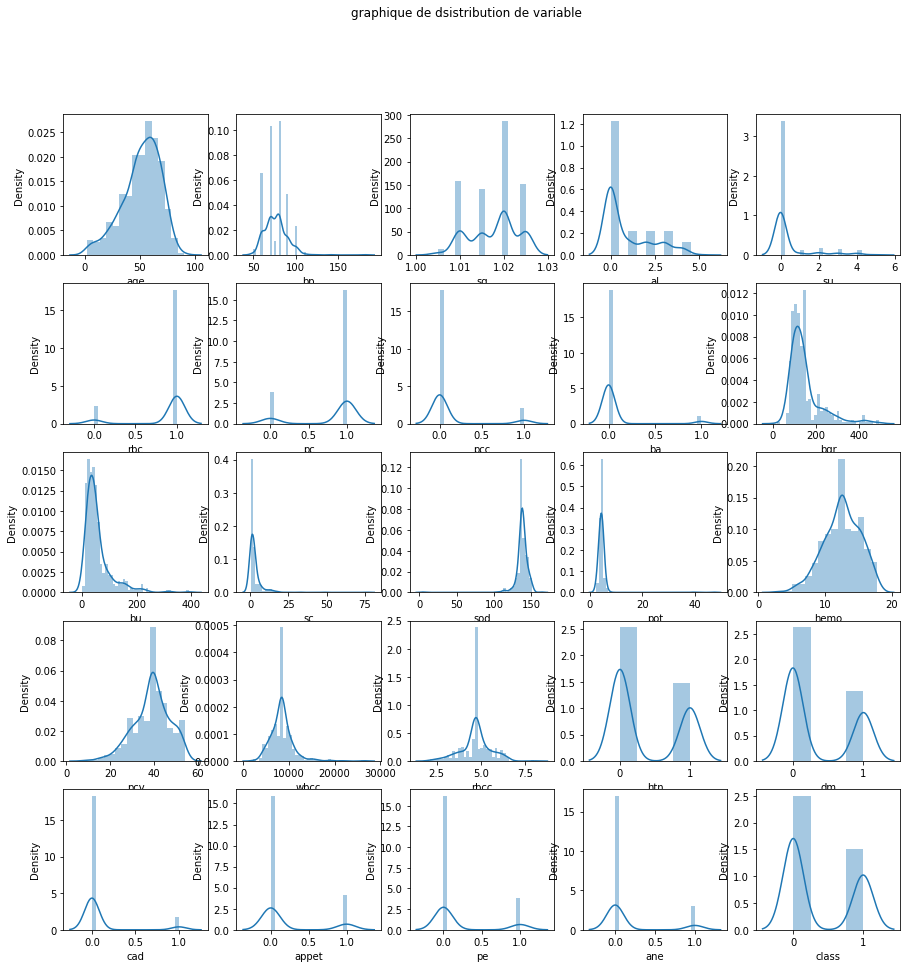

In [ ]:

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15,15))
fig.suptitle("graphique de distribution de variable ")
for col,ao in zip(df.columns.tolist(),axes.flatten()):
    print("oiiii",ao)
    sns.distplot(a=df[col],ax=ao)

# 3)Scaling :
* Il s'agit d'une Mise à l'échelle Cela aide essentiellement à normaliser les données dans une plage particulière, Pour accélérer les calculs.
* Elle supprime la moyenne et adapte chaque caractéristique/variable à la variance unitaire. Cette opération est effectuée par fonctionnalité de manière indépendante

In [ ]:

df[["age","su","bgr","bu","sc","sod","pot","hemo","pcv","wbcc","rbcc","bp"]]=StandardScaler().fit_transform(df[["age","su","bgr","bu","sc","sod","pot","hemo","pcv","wbcc","rbcc","bp"]])
df.describe()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
count,4.000000e+02,4.000000e+02,400.000000,400.00000,4.000000e+02,400.000000,400.000000,400.000000,400.000000,4.000000e+02,...,4.000000e+02,4.000000e+02,4.000000e+02,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,-7.827072e-17,-5.101475e-16,1.017712,0.90000,-2.456368e-16,0.882500,0.810000,0.105000,0.055000,5.384582e-17,...,-1.593170e-16,6.661338e-18,0.000000e+00,0.367500,0.34250,0.085000,0.205000,0.190000,0.150000,0.375000
std,1.001252e+00,1.001252e+00,0.005434,1.31313,1.001252e+00,0.322418,0.392792,0.306937,0.228266,1.001252e+00,...,1.001252e+00,1.001252e+00,1.001252e+00,0.482728,0.47514,0.279231,0.404207,0.392792,0.357519,0.484729
min,-2.918730e+00,-1.966580e+00,1.005000,0.00000,-3.802694e-01,0.000000,0.000000,0.000000,0.000000,-1.687482e+00,...,-3.670915e+00,-2.462684e+00,-3.106814e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-5.593680e-01,-4.806345e-01,1.015000,0.00000,-3.802694e-01,1.000000,1.000000,0.000000,0.000000,-6.297642e-01,...,-5.999959e-01,-5.678913e-01,-2.471631e-01,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.484407e-01,1.311692e-01,1.020000,0.00000,-3.802694e-01,1.000000,1.000000,0.000000,0.000000,-2.950433e-01,...,-1.065814e-16,-1.243450e-16,6.319578e-16,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.382812e-01,2.623384e-01,1.020000,2.00000,-3.802694e-01,1.000000,1.000000,0.000000,0.000000,2.628875e-02,...,6.283716e-01,3.943858e-01,4.677496e-01,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2.271867e+00,7.692067e+00,1.025000,5.00000,4.433268e+00,1.000000,1.000000,1.000000,1.000000,4.578493e+00,...,1.856739e+00,7.140246e+00,3.923161e+00,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


# **III) Réduction de la dimension :**
# 1)Feature selection :
On selectionne les feautres les plus importants pour l' entrainement de notre model on a Utilisé la methode RFE

Puisque on ne connait pas  en avance le nombre des features a selectioné on utilise RFECV

In [ ]:

clf = svm.SVC(kernel="linear")
sel1=RFECV(estimator=clf,step=1,cv=5)
sel2=sel1.fit(df.iloc[:,0:-1],df.iloc[:,-1])



eliminer les features qu'ils ne sont pas choisies par RFE

In [ ]:
y = df['class']
X=df.drop("class",axis=1)

X=X.iloc[:,sel2.ranking_==1]

print(df.corr())
print(X)

            age        bp        sg        al        su       rbc        pc  \
age    1.000000  0.148004 -0.159073  0.084416  0.187615 -0.011783 -0.101951   
bp     0.148004  1.000000 -0.164422  0.122541  0.190218 -0.151369 -0.156856   
sg    -0.159073 -0.164422  1.000000 -0.479962 -0.292053  0.253894  0.365353   
al     0.084416  0.122541 -0.479962  1.000000  0.287751 -0.394844 -0.561713   
su     0.187615  0.190218 -0.292053  0.287751  1.000000 -0.092940 -0.190062   
rbc   -0.011783 -0.151369  0.253894 -0.394844 -0.092940  1.000000  0.377394   
pc    -0.101951 -0.156856  0.365353 -0.561713 -0.190062  0.377394  1.000000   
pcc    0.159074  0.059560 -0.306426  0.417868  0.168091 -0.102948 -0.520118   
ba     0.043573  0.112173 -0.231704  0.377935  0.119399 -0.184402 -0.330401   
bgr    0.214410  0.149100 -0.317893  0.310481  0.629809 -0.153076 -0.262259   
bu     0.187544  0.183970 -0.249370  0.346935  0.126043 -0.236322 -0.344048   
sc     0.127316  0.144359 -0.176146  0.160252  0.094

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')
[ 3  4  5  6  9 10 11 12 13 14 15 17 18 19 21 22]
[6 2 4 1 1 1 1 7 8 1 1 1 1 1 1 1 5 1 1 1 9 1 1 3]
Optimal number of features : 16


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


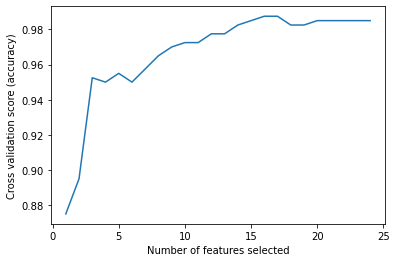

In [ ]:
print(df.columns)
print(sel2.get_support(indices=True))
print(sel2.ranking_)
print("Optimal number of features : %d" % sel2.n_features_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")

plt.plot(
    range(1, len(sel2.grid_scores_) + 1),
       sel2.cv_results_['mean_test_score']
)
plt.show()

# **IV) Training (Modélisation):**
# A)Apprentissage supervisé

**1)Classification:**

a) KNN:

La méthode train_test_split() est utilisée pour diviser nos données en ensembles d'entraînement et de test. Tout d'abord, nous devons diviser nos données en features(x) et labels(y)



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
# X_train=X_train.copy()
# for column in X_train.columns:
#     X_train[column] = (X_train[column] - X_train[column].min()) / (X_train[column].max() - X_train[column].min())
# X_train.describe()


# Hyperparameters
* On cherche le meilleur set of parameters qui donnera les meilleurs resultats avec 'GridSearchCV'
* On obtient 1 pour le nombre de neighbors et 1 pour le parameter p qui est la distance de manhattan

In [ ]:
n_neighbors = list(range(1,20))
p=[1,2]
hyperparameters = dict(n_neighbors=n_neighbors, p=p)

knn_2 = KNeighborsClassifier()
clf = GridSearchCV(knn_2, hyperparameters, cv=5)

best_model = clf.fit(X_train, y_train)

print( best_model.best_estimator_.get_params()['p'])
print( best_model.best_estimator_.get_params()['n_neighbors'])

2
1


In [ ]:

hyperparameters = dict(n_neighbors=n_neighbors, p=p)

scvG = svm.SVC()
clf = GridSearchCV(knn_2, hyperparameters, cv=5)

best_model = clf.fit(X_train, y_train)

print( best_model.best_estimator_.get_params()['p'])
print( best_model.best_estimator_.get_params()['n_neighbors'])

Test

In [ ]:
knn = KNeighborsClassifier(6,p=2)
knn_model = knn.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

**b) svm**



In [ ]:
d=svm.SVC(kernel="linear",C=10)
svm_model = d.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_knn))
print(accuracy_score(y_test, y_pred_knn))
print("ooo")
print(classification_report(y_test, y_pred_svm))



              precision    recall  f1-score   support

           0       1.00      0.97      0.98        62
           1       0.95      1.00      0.97        38

    accuracy                           0.98       100
   macro avg       0.97      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100

0.98
ooo
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        62
           1       0.95      1.00      0.97        38

    accuracy                           0.98       100
   macro avg       0.97      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



In [ ]:

from sklearn.model_selection import GridSearchCV
hyper=dict(criterion=['gini','entropy'],max_depth=range(1,12),random_state=0)
clt=GridSearchCV(rd,hyper)
clt.fit(X_train,y_train)
print(clt.best_estimator_.get_params()["criterion"])
print(clt.best_estimator_.get_params()["max_depth"])



entropy
5


**c) Decision Tree** :

Un autre moyen de classification est la "Decision Tree", c'est un modèle composé d'une collection de "questions" organisées de manière hiérarchique en forme d'arbre.
le "max_depth" est fixé a 8 ici et

on a obtenu une valeur d'accurancy = 99%


In [ ]:
rd=DecisionTreeClassifier(criterion="entropy",max_depth=8)
rd.fit(X_train,y_train)
y_pred=rd.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        62
           1       0.97      1.00      0.99        38

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

0.99


**d) Random Forest**:

* Random Forest est un algorithme d'apprentissage automatique supervisé puissant et polyvalent qui se développe et combine plusieurs arbres de décision pour créer une «forêt»
* La decision finale est celle choisit par la majorité des "Decision tree"
* Precision score est de valeur 0.97  et la valeur de l'accurancy est de 0.99
donc on conclut que le Random Forest depasse les autres algorithmes.



In [ ]:

rfc = RandomForestClassifier(criterion="entropy",max_depth=7, random_state=0)
rfc.fit(X_train,y_train)
print(clf.predict(X_test))
print(classification_report(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0
 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0
 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        62
           1       0.97      1.00      0.99        38

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

0.9743589743589743
0.99


#  Hyperparameter
* On cherche maintenant a savoir les meilleurs estimateurs qui donneront les meilleurs resultats.
* Pour ce faire on utilise le "GridSearchCV"
* On obtient au final les meilleurs estimateurs qui donneront le meilleur model
500 pou le n_estimators, 7 pour le max de depth, et entropy pour criterion




In [ ]:
rfc=RandomForestClassifier(entropy)
param_grid = {
    'n_estimators': [200, 500],

    'max_depth' : list(range(1,12)),
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=8, n_estimators=500,
                                              random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                         'n_estimators': [200, 500]})

In [ ]:
print(CV_rfc.best_estimator_.get_params()["n_estimators"])
print(CV_rfc.best_estimator_.get_params()["max_depth"])
print(CV_rfc.best_estimator_.get_params()["criterion"])

500
7
entropy
